# Connectivity detection: comparison between Granger causality and MAR 

This script compares the efficiency of conditional Granger causality (GC) analysis and a recent 
non-parametric testing method for connectivity detection in a multivariate autoregressive (MAR) proces. The MAR is a network with linear feedback in discrete time and is at the basis of GC analysis. 

The first part looks into the theory for two time series.

The second part examines the true-detection rates and false-alarm rates for network with random size, density, etc.

Ref:
- Gilson, Tauste Campo, Chen, Thiele, Deco (2018) Net Neurosci 1: 357-380; doi: 10.1162/NETN_a_00019
- Geweke (1982) J Am Stat Assoc 77: 304-313

In [6]:
import numpy as np
import scipy.stats as stt
import statsmodels.tsa.stattools as smtsa
import matplotlib.pyplot as pp

/Users/gilsonmatthieu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Example for two time series

We consider two time series $x^t$ and $y^t$. The question is whether there is an interactions between them.
We focus on the interaction $x \rightarrow y$ and consider a simple model: $x$ and $y$ are random vectors with unit variance, then $a x^{t-1}$ is simply added to $y^t$ with $a$ a coefficient that represents the strength of the interaction.

Granger causality considers the variance of the residuals of the linear regression of $y^t$ by $(y^{t-1}, x^{t-1})$:
$$ \epsilon_{x y} = \mathrm{linreg}(y^t | y^{t-1}, x^{t-1}) $$
and compares it with that of the residuals of $y^t$ by $y^{t-1}$:
$$ \epsilon_{y} = \mathrm{linreg}(y^t | y^{t-1}) .$$
The idea is that the second residuals will have larger variance if $x^t$ has there is an interaction.

interaction detected: [0.14113294] 0.04060954768145876

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7048  , p=0.4033  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.7268  , p=0.3939  , df=1
likelihood ratio test: chi2=0.7241  , p=0.3948  , df=1
parameter F test:         F=0.7048  , p=0.4033  , df_denom=96, df_num=1
{1: ({'ssr_ftest': (0.7047712181575533, 0.4032708916134131, 96.0, 1), 'ssr_chi2test': (0.7267953187249768, 0.3939239267800033, 1), 'lrtest': (0.724140468759856, 0.39478910962562797, 1), 'params_ftest': (0.7047712181575363, 0.4032708916134202, 96.0, 1)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x10debf630>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x10debfda0>, array([[0., 1., 0.]])])}


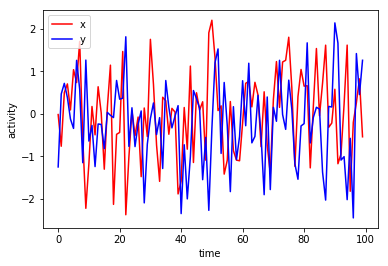

In [44]:
# generate time series
T = 100 # number of observed samples
x = np.random.randn(T)
y = np.random.randn(T)
a = 0.3 # interaction strength
y[1:] += a * x[:-1]

pp.figure()
pp.plot(x, c='r')
pp.plot(y, c='b')
pp.legend(['x','y'])
pp.xlabel('time')
pp.ylabel('activity')


# estimate ratio
res_x = np.linalg.lstsq(np.vstack((x[:-1],y[:-1])).T, y[1:], rcond=None)[1]                
res_nox = np.linalg.lstsq(y[:-1].reshape([-1,1]),y[1:], rcond=None)[1]
GC_est = np.log(res_nox/res_x)

# test with F statistics
pval = 0.05
lim_GC = stt.f.isf(pval,1,T-3)/(T-3) # threshold for parametric test
if GC_est>lim_GC:
    print('interaction detected:', GC_est, lim_GC)
else:
    print('interaction not detected:', GC_est, lim_GC)
    
# module from statsmodels
print(smtsa.grangercausalitytests(np.vstack((x,y)).T, maxlag=1))


pp.show()

Play with $a$ and $T$.

## Application to connectivity detection in a network 

The following code generates activity using a MAR process with a known connectivity (randomly chosen) and detects the original connectivity from the observed activity. It compares Granger causality and MAR estimate with non-parametric statistical testing. 

The MAR process is a multivariate signal (time series) $x^t = (x^t_i)$ with $1 \leq i \leq N$ defined in matrix form by
$$ x^{t+1} = A x^t + \zeta^t $$
where $A$ is the coupling matrix between the $N$ nodes. Compared to before, the time series depend on their own activity when the connectivity $A$ has loops. The nodes receive multivariate inputs that have spatial correlations (determined by the covariance matrix $\Sigma_{\rm orig} = \langle \zeta^t (\zeta^t)^T \rangle_t$, Sigma_orig in the script), but no temporal correlations. The superscript $T$ is the matrix transpose.

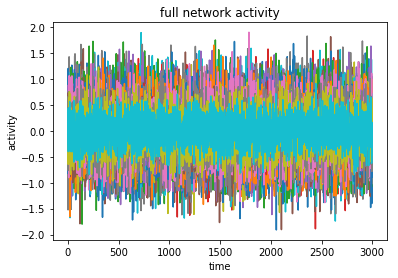

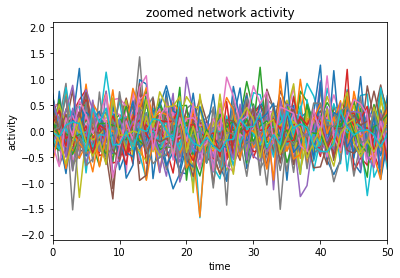

In [49]:
######################
# function definitions

def gen_random_A(p_arg,min_w_arg,max_w_arg):
    # creates a random matrix with probability of connection p_arg, and max weight w_arg
    A_tmp = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if np.random.rand()<p_arg:
                A_tmp[i,j] = min_w_arg+(max_w_arg-min_w_arg)*np.random.rand()
    return A_tmp

def run_sim_MAR(T1,T2,A_sim,S_sim):
    # generates the activitya of a MAR process with coupling A_sim and input covariances S_sim
    # time of simulation (the T1 period will be discarded)
    t_span = np.arange(T1+T2)
    # initialization
    x_tmp = np.random.rand(N)
    noise = np.random.normal(size=[T1+T2,N],scale=1.)
    # simulation and recording
    x_hist_tmp = np.zeros([T2,N])
    for t in t_span:
        x_tmp = np.dot(A_sim,x_tmp) + np.dot(S_sim,noise[t,:])
        if t>=T1:
            x_hist_tmp[t-T1,:] = x_tmp
    return x_hist_tmp


####################
# Network properties

# simulation duration
T = 3000 # duration of simulation
T0 = 1000 # initialization time for network dynamics

# number of network nodes
N = 50 #50+np.random.randint(101)

# connection density
p_A = 0.1+0.2*np.random.rand()

# weight bounds
max_w_A = (0.5+0.4*np.random.rand())/p_A/N
min_w_A = max_w_A*(0.5+0.5*np.random.rand())

# input noise matrix (diagonal on4ly so far)
noise_level = 0.25+0.5*np.random.rand()
spread_noise = np.random.rand()
offdiag_noise_coeff = np.random.rand()/5

# creates a randomly connected coupling matrix
A_orig = gen_random_A(p_A,min_w_A,max_w_A)

# creates the covariance matrix Sigma_orig from a random sparse matrix S_orig, which is its "square root"
if True:
    # independent inputs
    S_orig = noise_level*np.eye(N)
else:
    # spatially correlated inputs
    S_orig = noise_level*(np.eye(N) + offdiag_noise_coeff*gen_random_A(np.sqrt((0.05+0.45*np.random.rand())/N),0,1))
for i in range(N):
    S_orig[i,:] *= (1.-spread_noise/2+spread_noise*np.random.rand()) # modulation of diagonal elements of Sigma
Sigma_orig = np.dot(S_orig,S_orig.T)

# definition of masks for subsequent analysis
mask_diag = np.eye(N,dtype=np.bool) # diagonal elements
mask_offdiag = np.logical_not(mask_diag) # off-diagonal elements
mask_A_nonzero = A_orig>0 # existing connections in A
mask_A_zero = A_orig==0 #  absent connections in A


#############################
# network activity simulation
X = run_sim_MAR(T0,T,A_orig,S_orig)
if X.mean(0).max()>50:
    print('explosion with noise')
    sys.exit()

# center observed time series
t_X = np.array(X)
t_X -= np.outer(np.ones([t_X.shape[0]]),t_X.mean(0))

pp.figure()
pp.plot(range(T), t_X)
pp.xlabel('time')
pp.ylabel('activity')
pp.title('full network activity')

pp.figure()
pp.plot(range(T), t_X)
pp.axis(xmin=0,xmax=50)
pp.xlabel('time')
pp.ylabel('activity')
pp.title('zoomed network activity')

pp.show()

Now we turn to the detection of existing connections in $A$ from the observed activity above (of duration $T$). We compare the results using the MAR estimate and Granger causality analysis

The MAR estimate is calculated from the observed covariances:
$$ Q^\tau = \sum_t x^t (x^{t - \tau})^T $$
where $\tau \in \{0, 1\}$ is the time lag. With this convention (see the minus sign before $\tau$), the maximum likelihood estimate for the MAR is
$$ \hat{A} = Q^1 (Q^0)^{-1} . $$
The statistical testing is performed by calculating similar surrogate estimates after shuffling the observed time series (either time randomization or time rolling). Then, the detected connections are given by the MAR estimates that exceed a given threshold of the surrogate distribution (e.g. 98% percentile for a p-value of 0.02). Two methods are used, the global method where a single surrogate distribution is built for all connections, and the local method with a surrogate distribution per connection.

For GC analysis, we use a similar log-ratio as before, but we consider the linear regression of the target activity by 1) the activity of all nodes, then 2) the activity of all nodes except the source of the interaction tested (source->target). In practice, we remove each node at a time as a source to check all its possible outgoing connections (i.e. we test the columns of $A$).

network properties: 50 nodes with 28% density; min and max weights 0.04-0.05; input variances 0.35.

non-parametric MAR + local test:
false-alarm rate (expected 1,2,3,4,5%) [0.00788732 0.01690141 0.02422535 0.03267606 0.04225352]
true positive (for 2% expected false alarms): 492 for 725 existing connections

non-parametric MAR + global test:
false-alarm rate (expected 1,2,3,4,5%) [0.00788732 0.01971831 0.02535211 0.03661972 0.04450704]
true positive (for 2% expected false alarms): 433 for 725 existing connections

parametric Granger causality:
false-alarm rate (expected 1,2,3,4,5%) [0.00394366 0.01183099 0.01971831 0.0343662  0.04450704]
true positive (for 2% expected false alarms): 461 for 725 existing connections


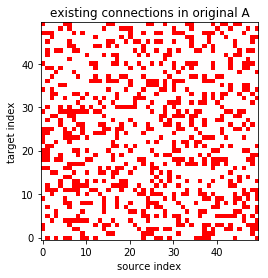

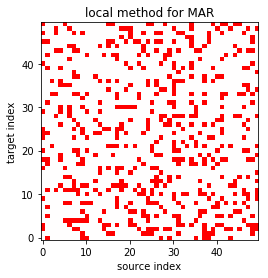

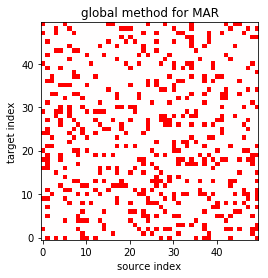

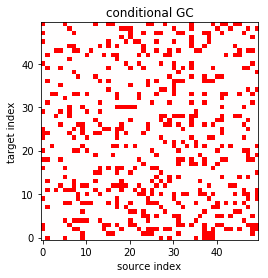

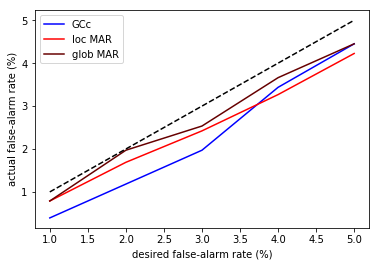

In [50]:
################################
# desired statistical sensitvity

n_pval = 5 # 5 p-values (1-5%) to test false-alarm rates
sensitivity = 0.02 # p-value for detection


##########################################################
# calculate MAR estimate and apply non-parametri shuffling
def MARnp(ts_arg):
    n_shuf = 200 # number of generated surrogates
    i_sensitivity = int(sensitivity*n_shuf) # equivalent threshold for n_shuf surrogates

    # structures to record results
    A_est = np.zeros([N,N]) # matrix of estimated MAR coefficients
    FP_A_est = np.zeros([n_pval,2]) # false-alarm rates for several p-values and 2 tests (local and global thresholds)
    detect_A_est = np.zeros([2,N,N],dtype=np.bool) # matrices of detected connections (same as before: local, global)

    # covariance matrices
    Q0 = np.tensordot(ts_arg[:-1,:],ts_arg[:-1,:],axes=[0,0])/float(t_X.shape[0]-2)
    Q1 = np.tensordot(ts_arg[1:,:],ts_arg[:-1,:],axes=[0,0])/float(t_X.shape[0]-2)
    # estimated MAR coefficients
    A_est = np.dot(Q1,np.linalg.pinv(Q0))

    # generation of surrogates
    A_est_shuf = np.zeros([n_shuf,N,N])

    for i_shuf in range(n_shuf):
        # copy original time series for manipulation
        ts_shuf = np.zeros([T,N])
        for i in range(N):
            ts_shuf[:,i] = ts_arg[np.argsort(np.random.rand(T)),i] # time permutation
    #        ts_shuf[:,i] = np.roll(ts_arg[:,i],np.random.randint(T)) # circular shift (time rolling)

        Q0_shuf_tmp = np.tensordot(ts_shuf[:-1,:],ts_shuf[:-1,:],axes=[0,0])/float(ts_arg.shape[0]-2)
        Q1_shuf_tmp = np.tensordot(ts_shuf[1:,:],ts_shuf[:-1,:],axes=[0,0])/float(ts_arg.shape[0]-2)
        A_est_shuf[i_shuf,:,:] = np.dot(Q1_shuf_tmp,np.linalg.pinv(Q0_shuf_tmp))

    max_A_est_ij = np.sort(A_est_shuf,axis=0) # sort surrogate values for each matrix element
    max_A_est_global = np.sort(A_est_shuf,axis=None) # sort surrogate values pooling all elements

    # calculate false alarm rate
    for i_pval in range(n_pval):
        FP_A_est[i_pval,0] = np.sum(A_est[mask_A_zero]>=max_A_est_ij[-int((1+i_pval)/100.*n_shuf),mask_A_zero])/float(mask_A_zero.sum())
        FP_A_est[i_pval,1] = np.sum(A_est[mask_A_zero]>=max_A_est_global[-int((1+i_pval)/100.*n_shuf*(N**2))])/float(mask_A_zero.sum())

    # significance test for estimated MAR
    detect_A_est[0,:,:] = A_est>=max_A_est_ij[-i_sensitivity,:,:]
    detect_A_est[1,:,:] = A_est>=max_A_est_global[-int(i_sensitivity*(N**2))]

    return FP_A_est, detect_A_est


########################################
# conditional Granger causality analysis
def GCc(ts_arg):
    # structures to record results
    A_est = np.zeros([N,N]) # matrix of log ratio
    FP_A_est = np.zeros([n_pval]) # false-alarm rates for several p-values
    detect_A_est = np.zeros([N,N],dtype=np.bool) # matrices of detected connections

    # estimate log ratios
    res_full = np.linalg.lstsq(ts_arg[:-1,:],ts_arg[1:,:],rcond=None)[1]                
    for j in range(N):
        v_bool = np.ones([N],dtype=np.bool)
        v_bool[j] = False
        res_noj = np.linalg.lstsq(ts_arg[:-1,v_bool],ts_arg[1:,:],rcond=None)[1]
        A_est[:,j] = np.log(res_noj/res_full)

    # calculate false alarm rate
    for i_pval in range(n_pval):
        lim_GCc = stt.f.isf((i_pval+1)/100.,1,T-N-1)/(T-N-1) # threshold for parametric test
        FP_A_est[i_pval] = np.sum(A_est[mask_A_zero]>=lim_GCc)/float(mask_A_zero.sum())

    # significance test for Granger causality analysis
    lim_GCc = stt.f.isf(sensitivity,1,T-N-1)/(T-N-1) # threshold for parametric test 
    detect_A_est = np.exp(A_est)-1>=lim_GCc
    
    return FP_A_est, detect_A_est


#################
# display results

FP_A_MAR, detect_A_MAR = MARnp(t_X)
FP_A_GCc_param, detect_A_GCc_param = GCc(t_X)

print('network properties: {0:d} nodes with {1:d}% density; min and max weights {2:.2f}-{3:.2f}; input variances {4:.2f}.'.format(N, int(100*p_A), min_w_A, max_w_A, noise_level))
print()

print('non-parametric MAR + local test:')
i_type_ref = 0
print('false-alarm rate (expected 1,2,3,4,5%)', FP_A_MAR[:,i_type_ref])
print('true positive (for {0:d}% expected false alarms):'.format(int(100*sensitivity)), np.logical_and(detect_A_MAR[i_type_ref,:,:],A_orig>0).sum(), 'for', (A_orig>0).sum(), 'existing connections')
print()
i_type_ref = 1
print('non-parametric MAR + global test:')
print('false-alarm rate (expected 1,2,3,4,5%)', FP_A_MAR[:,i_type_ref])
print('true positive (for {0:d}% expected false alarms):'.format(int(100*sensitivity)), np.logical_and(detect_A_MAR[i_type_ref,:,:],A_orig>0).sum(), 'for', (A_orig>0).sum(), 'existing connections')
print()
print('parametric Granger causality:')
print('false-alarm rate (expected 1,2,3,4,5%)', FP_A_GCc_param)
print('true positive (for {0:d}% expected false alarms):'.format(int(100*sensitivity)), np.logical_and(detect_A_GCc_param,A_orig>0).sum(), 'for', (A_orig>0).sum(), 'existing connections')


pp.figure()
pp.imshow(mask_A_nonzero, interpolation='nearest', origin='bottom', vmin=-1, vmax=1, cmap='bwr')
pp.xlabel('source index')
pp.ylabel('target index')
pp.title('existing connections in original A')

pp.figure()
pp.imshow(detect_A_MAR[0,:,:], interpolation='nearest', origin='bottom', vmin=-1, vmax=1, cmap='bwr')
pp.xlabel('source index')
pp.ylabel('target index')
pp.title('local method for MAR')

pp.figure()
pp.imshow(detect_A_MAR[1,:,:], interpolation='nearest', origin='bottom', vmin=-1, vmax=1, cmap='bwr')
pp.xlabel('source index')
pp.ylabel('target index')
pp.title('global method for MAR')

pp.figure()
pp.imshow(detect_A_GCc_param, interpolation='nearest', origin='bottom', vmin=-1, vmax=1, cmap='bwr')
pp.xlabel('source index')
pp.ylabel('target index')
pp.title('conditional GC')

pp.figure()
pp.plot((np.arange(n_pval)+1), 100*FP_A_GCc_param, c='b', lw=1.5)
pp.plot((np.arange(n_pval)+1), 100*FP_A_MAR[:,0], c='r', lw=1.5)
pp.plot((np.arange(n_pval)+1), 100*FP_A_MAR[:,1], c=[0.4,0,0], lw=1.5)
pp.legend(['GCc', 'loc MAR', 'glob MAR'])
pp.plot((np.arange(n_pval)+1), (np.arange(n_pval)+1), '--k')
pp.xlabel('desired false-alarm rate (%)')
pp.ylabel('actual false-alarm rate (%)')

pp.show()

# Exercices

- Start with "small" networks (N = 20 nodes) to compare Granger causality and vary the number of node (N) and the density (p_C) to see the trend.
- Make a loop to simulate many networks (20-50 repetitions) to quantitatively compare the performance of the methods as a function of the network density (p_C), controling for the network size.
- Check the effect of spatially correlated inputs (versus independent).

## Extra

- Compare with partial correlation for detecting the symmetric part of the original connectiivty.
- Compare computation cost (speed) of each method